In [40]:
!pip install transformers torch scikit-learn matplotlib -q


In [41]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight


In [42]:
df = pd.read_csv(
    '/content/diabetic_data.csv',
    nrows=1000
)


for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

df['label'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print("Original distribution:\n", df['label'].value_counts())


Original distribution:
 label
0    906
1     94
Name: count, dtype: int64


/tmp/ipython-input-1278499667.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1278499667.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [47]:
from sklearn.utils import resample

df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced distribution:\n", df_balanced['label'].value_counts())

Balanced distribution:
 label
1    906
0    906
Name: count, dtype: int64


In [48]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_balanced['diag_1'], df_balanced['label'],
    test_size=0.3, stratify=df_balanced['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=1/3, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")


Train: 1268, Val: 362, Test: 182


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

df = pd.read_csv(
    '/content/diabetic_data.csv',
    nrows=1000
)

for col in df.columns:
    if df[col].dtype == 'object':
        df.loc[:, col].fillna(df[col].mode()[0], inplace=True)
    else:
        df.loc[:, col].fillna(df[col].median(), inplace=True)

df['label'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print("Original distribution:\n", df['label'].value_counts())

from sklearn.utils import resample

df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print("Balanced distribution:\n", df_balanced['label'].value_counts())

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_balanced['diag_1'], df_balanced['label'],
    test_size=0.3, stratify=df_balanced['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=1/3, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")

Using device: cuda
Original distribution:
 label
0    906
1     94
Name: count, dtype: int64
Balanced distribution:
 label
1    906
0    906
Name: count, dtype: int64
Train: 1268, Val: 362, Test: 182


/tmp/ipython-input-3972627132.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:, col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-3972627132.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [70]:
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def encode_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True, return_tensors="pt")

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)
test_encodings = encode_texts(test_texts)

train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)
test_labels_tensor = torch.tensor(test_labels.values)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

train_dataset = CustomDataset(train_encodings, train_labels_tensor)
val_dataset = CustomDataset(val_encodings, val_labels_tensor)
test_dataset = CustomDataset(test_encodings, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=2
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_tensor.cpu().numpy()),
    y=train_labels_tensor.cpu().numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

def train_model(model, optimizer, train_loader, val_loader, num_epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):

        model.train()
        total_loss, correct, total = 0, 0, 0
        train_preds, train_labels_list = [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_labels_list, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels_list, train_preds, average='weighted', zero_division=0)
        train_mcc = matthews_corrcoef(train_labels_list, train_preds)
        train_mae = mean_absolute_error(train_labels_list, train_preds)
        train_mse = mean_squared_error(train_labels_list, train_preds)
        train_rmse = np.sqrt(train_mse)
        train_kappa = cohen_kappa_score(train_labels_list, train_preds)


        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_preds, val_labels_list, val_probs_list = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                probs = torch.softmax(outputs.logits, dim=1)[:, 1]
                preds = torch.argmax(outputs.logits, dim=1)

                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())
                val_probs_list.extend(probs.cpu().numpy())

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels_list, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels_list, val_preds, average='weighted', zero_division=0)
        val_mcc = matthews_corrcoef(val_labels_list, val_preds)
        val_mae = mean_absolute_error(val_labels_list, val_preds)
        val_mse = mean_squared_error(val_labels_list, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_kappa = cohen_kappa_score(val_labels_list, val_preds)
        try:
            val_auc = roc_auc_score(val_labels_list, val_probs_list)
        except ValueError:
             val_auc = float('nan')


        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        print(f"  Train Metrics: Acc={train_acc:.4f}, Prec={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}, MCC={train_mcc:.4f}, MAE={train_mae:.4f}, MSE={train_mse:.4f}, RMSE={train_rmse:.4f}, Kappa={train_kappa:.4f}")
        print(f"  Val Metrics:   Acc={val_acc:.4f}, Prec={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}, MCC={val_mcc:.4f}, MAE={val_mae:.4f}, MSE={val_mse:.4f}, RMSE={val_rmse:.4f}, Kappa={val_kappa:.4f}, AUC={val_auc:.4f}")


        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    return history

history = train_model(model, optimizer, train_loader, val_loader, num_epochs=10)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 80/80 [00:06<00:00, 11.81it/s]


Epoch 1: Train Loss=0.7054, Val Loss=0.6938
  Train Metrics: Acc=0.5118, Prec=0.5119, Recall=0.5118, F1=0.5108, MCC=0.0238, MAE=0.4882, MSE=0.4882, RMSE=0.6987, Kappa=0.0237
  Val Metrics:   Acc=0.5028, Prec=0.5364, Recall=0.5028, F1=0.3534, MCC=0.0201, MAE=0.4972, MSE=0.4972, RMSE=0.7052, Kappa=0.0055, AUC=0.5827


Epoch 2: 100%|██████████| 80/80 [00:05<00:00, 14.10it/s]


Epoch 2: Train Loss=0.6862, Val Loss=0.6652
  Train Metrics: Acc=0.5418, Prec=0.5419, Recall=0.5418, F1=0.5416, MCC=0.0837, MAE=0.4582, MSE=0.4582, RMSE=0.6769, Kappa=0.0836
  Val Metrics:   Acc=0.5994, Prec=0.6008, Recall=0.5994, F1=0.5981, MCC=0.2002, MAE=0.4006, MSE=0.4006, RMSE=0.6329, Kappa=0.1989, AUC=0.6414


Epoch 3: 100%|██████████| 80/80 [00:05<00:00, 14.74it/s]


Epoch 3: Train Loss=0.6625, Val Loss=0.6723
  Train Metrics: Acc=0.5915, Prec=0.5918, Recall=0.5915, F1=0.5912, MCC=0.1833, MAE=0.4085, MSE=0.4085, RMSE=0.6392, Kappa=0.1830
  Val Metrics:   Acc=0.5773, Prec=0.5789, Recall=0.5773, F1=0.5753, MCC=0.1562, MAE=0.4227, MSE=0.4227, RMSE=0.6501, Kappa=0.1547, AUC=0.6398


Epoch 4: 100%|██████████| 80/80 [00:05<00:00, 14.07it/s]


Epoch 4: Train Loss=0.6562, Val Loss=0.6613
  Train Metrics: Acc=0.6104, Prec=0.6104, Recall=0.6104, F1=0.6104, MCC=0.2208, MAE=0.3896, MSE=0.3896, RMSE=0.6242, Kappa=0.2208
  Val Metrics:   Acc=0.6298, Prec=0.6415, Recall=0.6298, F1=0.6220, MCC=0.2711, MAE=0.3702, MSE=0.3702, RMSE=0.6084, Kappa=0.2597, AUC=0.6712


Epoch 5: 100%|██████████| 80/80 [00:05<00:00, 15.23it/s]


Epoch 5: Train Loss=0.6077, Val Loss=0.6319
  Train Metrics: Acc=0.6782, Prec=0.6783, Recall=0.6782, F1=0.6782, MCC=0.3565, MAE=0.3218, MSE=0.3218, RMSE=0.5672, Kappa=0.3565
  Val Metrics:   Acc=0.6519, Prec=0.6547, Recall=0.6519, F1=0.6504, MCC=0.3066, MAE=0.3481, MSE=0.3481, RMSE=0.5900, Kappa=0.3039, AUC=0.7048


Epoch 6: 100%|██████████| 80/80 [00:05<00:00, 14.14it/s]


Epoch 6: Train Loss=0.5902, Val Loss=0.6359
  Train Metrics: Acc=0.6893, Prec=0.6928, Recall=0.6893, F1=0.6878, MCC=0.3821, MAE=0.3107, MSE=0.3107, RMSE=0.5574, Kappa=0.3785
  Val Metrics:   Acc=0.6354, Prec=0.6486, Recall=0.6354, F1=0.6271, MCC=0.2836, MAE=0.3646, MSE=0.3646, RMSE=0.6039, Kappa=0.2707, AUC=0.6952


Epoch 7: 100%|██████████| 80/80 [00:05<00:00, 15.09it/s]


Epoch 7: Train Loss=0.5748, Val Loss=0.5959
  Train Metrics: Acc=0.6987, Prec=0.7018, Recall=0.6987, F1=0.6976, MCC=0.4005, MAE=0.3013, MSE=0.3013, RMSE=0.5489, Kappa=0.3975
  Val Metrics:   Acc=0.6796, Prec=0.6810, Recall=0.6796, F1=0.6789, MCC=0.3605, MAE=0.3204, MSE=0.3204, RMSE=0.5661, Kappa=0.3591, AUC=0.7354


Epoch 8: 100%|██████████| 80/80 [00:05<00:00, 14.11it/s]


Epoch 8: Train Loss=0.5504, Val Loss=0.5812
  Train Metrics: Acc=0.7066, Prec=0.7098, Recall=0.7066, F1=0.7055, MCC=0.4164, MAE=0.2934, MSE=0.2934, RMSE=0.5416, Kappa=0.4132
  Val Metrics:   Acc=0.6685, Prec=0.6747, Recall=0.6685, F1=0.6656, MCC=0.3431, MAE=0.3315, MSE=0.3315, RMSE=0.5758, Kappa=0.3370, AUC=0.7416


Epoch 9: 100%|██████████| 80/80 [00:05<00:00, 15.02it/s]


Epoch 9: Train Loss=0.5401, Val Loss=0.5788
  Train Metrics: Acc=0.7137, Prec=0.7186, Recall=0.7137, F1=0.7121, MCC=0.4323, MAE=0.2863, MSE=0.2863, RMSE=0.5350, Kappa=0.4274
  Val Metrics:   Acc=0.6547, Prec=0.6549, Recall=0.6547, F1=0.6546, MCC=0.3096, MAE=0.3453, MSE=0.3453, RMSE=0.5876, Kappa=0.3094, AUC=0.7460


Epoch 10: 100%|██████████| 80/80 [00:05<00:00, 14.09it/s]


Epoch 10: Train Loss=0.5287, Val Loss=0.5771
  Train Metrics: Acc=0.7043, Prec=0.7076, Recall=0.7043, F1=0.7030, MCC=0.4119, MAE=0.2957, MSE=0.2957, RMSE=0.5438, Kappa=0.4085
  Val Metrics:   Acc=0.6768, Prec=0.6821, Recall=0.6768, F1=0.6744, MCC=0.3589, MAE=0.3232, MSE=0.3232, RMSE=0.5685, Kappa=0.3536, AUC=0.7452



Test Results (with threshold = 0.45):
              precision    recall  f1-score   support

           0     0.7925    0.4615    0.5833        91
           1     0.6202    0.8791    0.7273        91

    accuracy                         0.6703       182
   macro avg     0.7063    0.6703    0.6553       182
weighted avg     0.7063    0.6703    0.6553       182

ROC-AUC: 0.7377732157951938


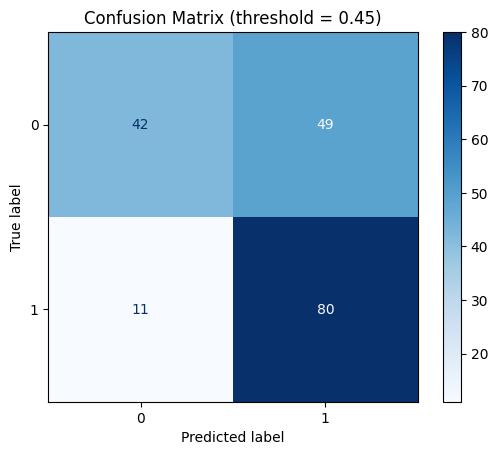

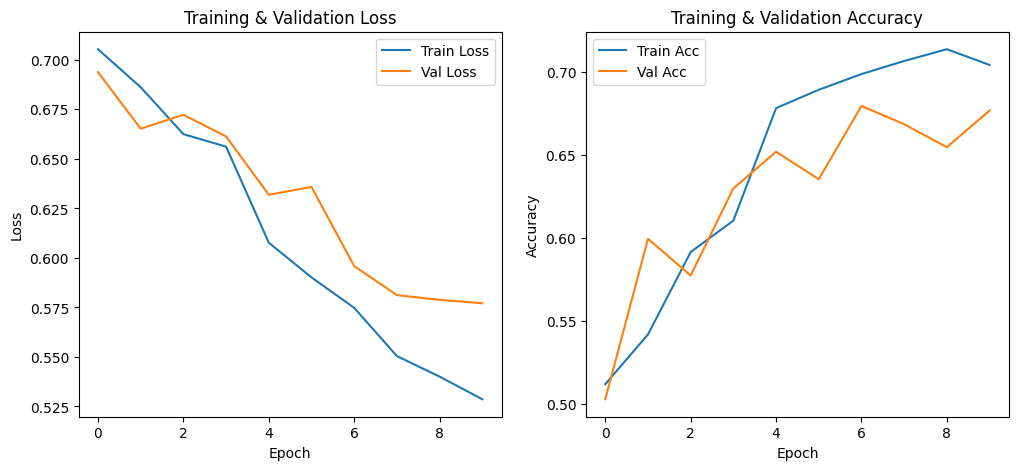

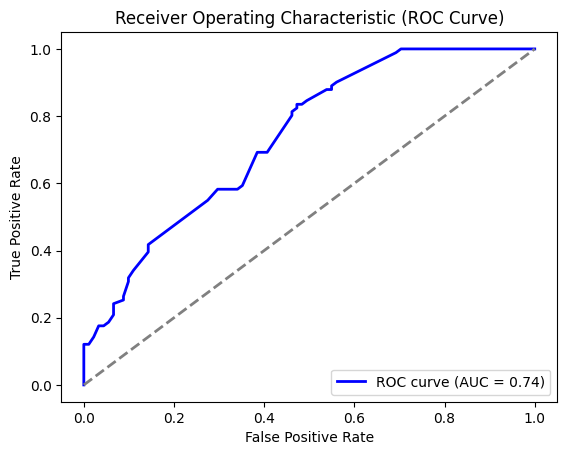

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, classification_report

model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Apply the chosen threshold
chosen_threshold = 0.45
all_preds = (np.array(all_probs) > chosen_threshold).astype(int)


print("\nTest Results (with threshold = {:.2f}):".format(chosen_threshold))
print(classification_report(all_labels, all_preds, digits=4))

try:
    roc_auc_clinical = roc_auc_score(all_labels, all_probs)
    print("ROC-AUC:", roc_auc_clinical)
except ValueError:
    print("ROC-AUC: Could not calculate (only one class present in test_labels)")


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (threshold = {:.2f})".format(chosen_threshold))
plt.show()


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC Curve)")
plt.legend(loc="lower right")
plt.show()

In [63]:
bert_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(device)

bert_optimizer = AdamW(bert_model.parameters(), lr=2e-5)
bert_loss_fn = nn.CrossEntropyLoss()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:

def train_model(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=3):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):

        model.train()
        total_loss, correct, total = 0, 0, 0
        train_preds, train_labels_list = [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels_list.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)


        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_labels_list, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_labels_list, train_preds, average='weighted', zero_division=0)
        train_mcc = matthews_corrcoef(train_labels_list, train_preds)
        train_mae = mean_absolute_error(train_labels_list, train_preds)
        train_mse = mean_squared_error(train_labels_list, train_preds)
        train_rmse = np.sqrt(train_mse)
        train_kappa = cohen_kappa_score(train_labels_list, train_preds)


        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_preds, val_labels_list, val_probs_list = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                val_loss += loss.item()

                probs = torch.softmax(outputs.logits, dim=1)[:, 1]
                preds = torch.argmax(outputs.logits, dim=1)

                val_preds.extend(preds.cpu().numpy())
                val_labels_list.extend(labels.cpu().numpy())
                val_probs_list.extend(probs.cpu().numpy())

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels_list, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels_list, val_preds, average='weighted', zero_division=0)
        val_mcc = matthews_corrcoef(val_labels_list, val_preds)
        val_mae = mean_absolute_error(val_labels_list, val_preds)
        val_mse = mean_squared_error(val_labels_list, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_kappa = cohen_kappa_score(val_labels_list, val_preds)
        try:
            val_auc = roc_auc_score(val_labels_list, val_probs_list)
        except ValueError:
             val_auc = float('nan')


        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        print(f"  Train Metrics: Acc={train_acc:.4f}, Prec={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}, MCC={train_mcc:.4f}, MAE={train_mae:.4f}, MSE={train_mse:.4f}, RMSE={train_rmse:.4f}, Kappa={train_kappa:.4f}")
        print(f"  Val Metrics:   Acc={val_acc:.4f}, Prec={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}, MCC={val_mcc:.4f}, MAE={val_mae:.4f}, MSE={val_mse:.4f}, RMSE={val_rmse:.4f}, Kappa={val_kappa:.4f}, AUC={val_auc:.4f}")


        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    return history
bert_history = train_model(
    bert_model, bert_optimizer, bert_loss_fn, train_loader, val_loader, num_epochs=10
)

Epoch 1: 100%|██████████| 80/80 [00:05<00:00, 14.79it/s]


Epoch 1: Train Loss=0.6918, Val Loss=0.6713
  Train Metrics: Acc=0.5355, Prec=0.5355, Recall=0.5355, F1=0.5355, MCC=0.0710, MAE=0.4645, MSE=0.4645, RMSE=0.6816, Kappa=0.0710
  Val Metrics:   Acc=0.5967, Prec=0.6034, Recall=0.5967, F1=0.5901, MCC=0.1999, MAE=0.4033, MSE=0.4033, RMSE=0.6351, Kappa=0.1934, AUC=0.6361


Epoch 2: 100%|██████████| 80/80 [00:05<00:00, 14.12it/s]


Epoch 2: Train Loss=0.6587, Val Loss=0.6728
  Train Metrics: Acc=0.6073, Prec=0.6078, Recall=0.6073, F1=0.6067, MCC=0.2151, MAE=0.3927, MSE=0.3927, RMSE=0.6267, Kappa=0.2145
  Val Metrics:   Acc=0.5939, Prec=0.6122, Recall=0.5939, F1=0.5767, MCC=0.2053, MAE=0.4061, MSE=0.4061, RMSE=0.6372, Kappa=0.1878, AUC=0.6403


Epoch 3: 100%|██████████| 80/80 [00:05<00:00, 15.06it/s]


Epoch 3: Train Loss=0.6328, Val Loss=0.6588
  Train Metrics: Acc=0.6380, Prec=0.6422, Recall=0.6380, F1=0.6353, MCC=0.2802, MAE=0.3620, MSE=0.3620, RMSE=0.6017, Kappa=0.2760
  Val Metrics:   Acc=0.6575, Prec=0.6575, Recall=0.6575, F1=0.6574, MCC=0.3150, MAE=0.3425, MSE=0.3425, RMSE=0.5853, Kappa=0.3149, AUC=0.7043


Epoch 4: 100%|██████████| 80/80 [00:05<00:00, 14.04it/s]


Epoch 4: Train Loss=0.5962, Val Loss=0.6145
  Train Metrics: Acc=0.6790, Prec=0.6830, Recall=0.6790, F1=0.6773, MCC=0.3620, MAE=0.3210, MSE=0.3210, RMSE=0.5665, Kappa=0.3580
  Val Metrics:   Acc=0.6575, Prec=0.6603, Recall=0.6575, F1=0.6559, MCC=0.3177, MAE=0.3425, MSE=0.3425, RMSE=0.5853, Kappa=0.3149, AUC=0.7263


Epoch 5: 100%|██████████| 80/80 [00:07<00:00, 10.99it/s]


Epoch 5: Train Loss=0.5771, Val Loss=0.6133
  Train Metrics: Acc=0.6877, Prec=0.6906, Recall=0.6877, F1=0.6865, MCC=0.3783, MAE=0.3123, MSE=0.3123, RMSE=0.5588, Kappa=0.3754
  Val Metrics:   Acc=0.6823, Prec=0.6844, Recall=0.6823, F1=0.6814, MCC=0.3667, MAE=0.3177, MSE=0.3177, RMSE=0.5636, Kappa=0.3646, AUC=0.7365


Epoch 6: 100%|██████████| 80/80 [00:05<00:00, 13.99it/s]


Epoch 6: Train Loss=0.5683, Val Loss=0.5963
  Train Metrics: Acc=0.7003, Prec=0.7052, Recall=0.7003, F1=0.6985, MCC=0.4055, MAE=0.2997, MSE=0.2997, RMSE=0.5474, Kappa=0.4006
  Val Metrics:   Acc=0.6630, Prec=0.6659, Recall=0.6630, F1=0.6615, MCC=0.3289, MAE=0.3370, MSE=0.3370, RMSE=0.5805, Kappa=0.3260, AUC=0.7362


Epoch 7: 100%|██████████| 80/80 [00:05<00:00, 14.92it/s]


Epoch 7: Train Loss=0.5361, Val Loss=0.5787
  Train Metrics: Acc=0.6932, Prec=0.6991, Recall=0.6932, F1=0.6909, MCC=0.3923, MAE=0.3068, MSE=0.3068, RMSE=0.5539, Kappa=0.3864
  Val Metrics:   Acc=0.6713, Prec=0.6796, Recall=0.6713, F1=0.6674, MCC=0.3508, MAE=0.3287, MSE=0.3287, RMSE=0.5733, Kappa=0.3425, AUC=0.7439


Epoch 8: 100%|██████████| 80/80 [00:05<00:00, 14.05it/s]


Epoch 8: Train Loss=0.5251, Val Loss=0.5726
  Train Metrics: Acc=0.7129, Prec=0.7235, Recall=0.7129, F1=0.7095, MCC=0.4363, MAE=0.2871, MSE=0.2871, RMSE=0.5358, Kappa=0.4259
  Val Metrics:   Acc=0.6685, Prec=0.6687, Recall=0.6685, F1=0.6684, MCC=0.3372, MAE=0.3315, MSE=0.3315, RMSE=0.5758, Kappa=0.3370, AUC=0.7418


Epoch 9: 100%|██████████| 80/80 [00:05<00:00, 15.01it/s]


Epoch 9: Train Loss=0.5274, Val Loss=0.5760
  Train Metrics: Acc=0.7043, Prec=0.7107, Recall=0.7043, F1=0.7020, MCC=0.4149, MAE=0.2957, MSE=0.2957, RMSE=0.5438, Kappa=0.4085
  Val Metrics:   Acc=0.6961, Prec=0.6991, Recall=0.6961, F1=0.6950, MCC=0.3952, MAE=0.3039, MSE=0.3039, RMSE=0.5512, Kappa=0.3923, AUC=0.7511


Epoch 10: 100%|██████████| 80/80 [00:05<00:00, 14.02it/s]


Epoch 10: Train Loss=0.5191, Val Loss=0.5882
  Train Metrics: Acc=0.7200, Prec=0.7267, Recall=0.7200, F1=0.7179, MCC=0.4467, MAE=0.2800, MSE=0.2800, RMSE=0.5291, Kappa=0.4401
  Val Metrics:   Acc=0.6740, Prec=0.6821, Recall=0.6740, F1=0.6704, MCC=0.3560, MAE=0.3260, MSE=0.3260, RMSE=0.5709, Kappa=0.3481, AUC=0.7472


In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

bert_model.eval()
bert_preds, bert_labels, bert_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        preds = torch.argmax(outputs.logits, dim=1)

        bert_preds.extend(preds.cpu().numpy())
        bert_labels.extend(labels.cpu().numpy())
        bert_probs.extend(probs.cpu().numpy())

print("\nBERT-base Test Results:")
print(classification_report(bert_labels, bert_preds, digits=4))
print("ROC-AUC:", roc_auc_score(bert_labels, bert_probs))



BERT-base Test Results:
              precision    recall  f1-score   support

           0     0.7377    0.4945    0.5921        91
           1     0.6198    0.8242    0.7075        91

    accuracy                         0.6593       182
   macro avg     0.6788    0.6593    0.6498       182
weighted avg     0.6788    0.6593    0.6498       182

ROC-AUC: 0.7254558628185002


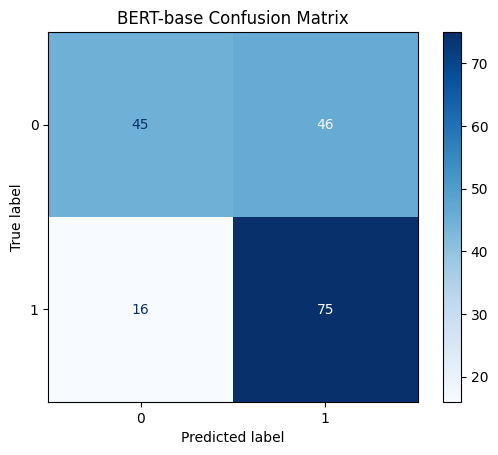

In [68]:
cm = confusion_matrix(bert_labels, bert_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format="d")
plt.title("BERT-base Confusion Matrix")
plt.show()

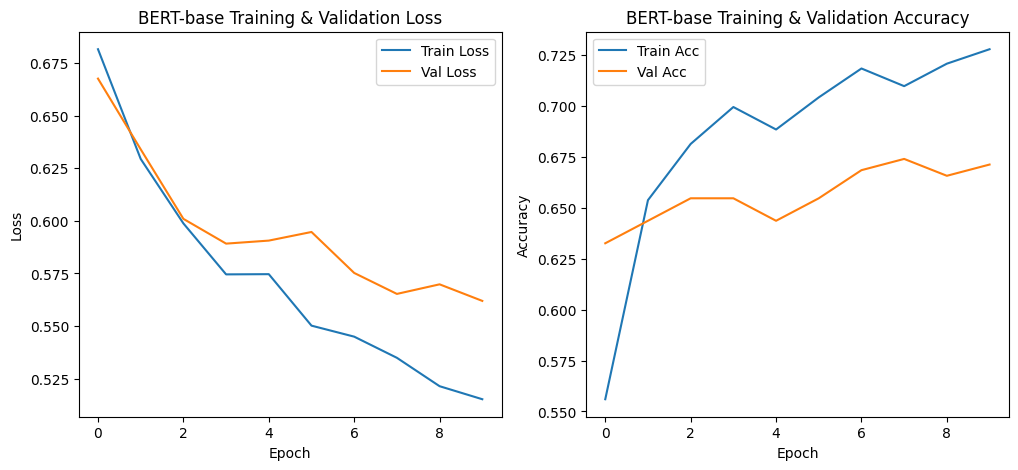

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bert_history["train_loss"], label="Train Loss")
plt.plot(bert_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT-base Training & Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bert_history["train_acc"], label="Train Acc")
plt.plot(bert_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("BERT-base Training & Validation Accuracy")
plt.legend()

plt.show()


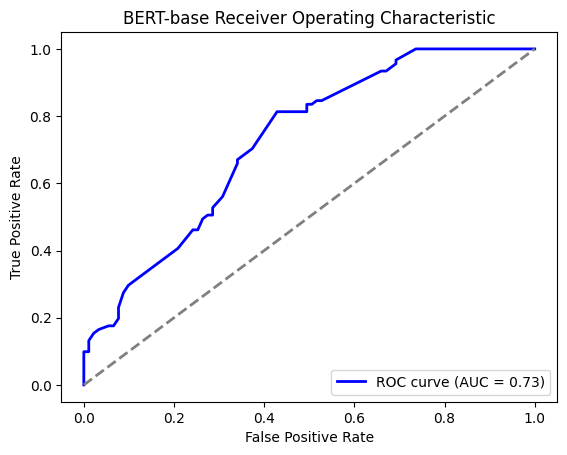

In [38]:
fpr, tpr, thresholds = roc_curve(bert_labels, bert_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BERT-base Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


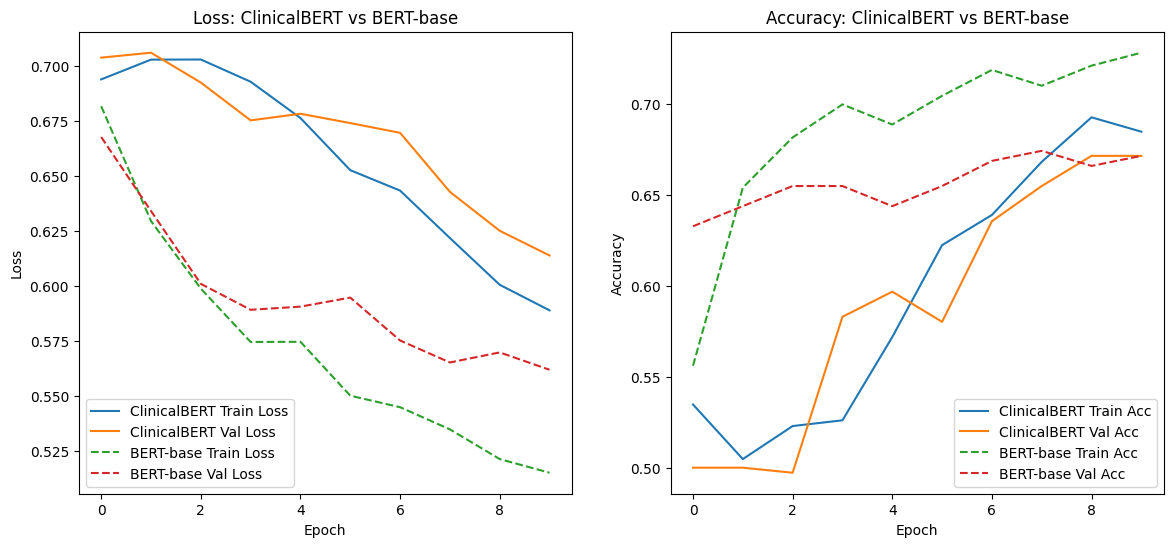

In [39]:
# 15. Compare Training Curves
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Loss comparison
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="ClinicalBERT Train Loss")
plt.plot(history["val_loss"], label="ClinicalBERT Val Loss")
plt.plot(bert_history["train_loss"], label="BERT-base Train Loss", linestyle="--")
plt.plot(bert_history["val_loss"], label="BERT-base Val Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss: ClinicalBERT vs BERT-base")
plt.legend()

# Accuracy comparison
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="ClinicalBERT Train Acc")
plt.plot(history["val_acc"], label="ClinicalBERT Val Acc")
plt.plot(bert_history["train_acc"], label="BERT-base Train Acc", linestyle="--")
plt.plot(bert_history["val_acc"], label="BERT-base Val Acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy: ClinicalBERT vs BERT-base")
plt.legend()

plt.show()